In [1]:
import pandas as pd 
import numpy as np
import mlflow

## Leitura dos Dados

In [2]:
# X = np.load("X-mel_spec.npy")
# y = np.load("y-mel_spec.npy")

X = np.load("X-PCP.npy")
y = np.load("y-PCP.npy")

In [3]:
def get_label(filepath):

    metadata = pd.read_csv('metadata.csv', sep = ',')
    chords = {}

    filename = filepath.split('/')[1]
    chord = metadata[metadata['Filename'] == filename]['Acorde'].values[0]

    return chord

#metadata with most_freq chords indicator
df = pd.read_csv('metadata_final.csv', sep = ',')
df_chords = df[df['most_freq'] == 1]

## Divisão Treino e Teste

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Métricas

In [5]:
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import classification_report


def metrics(model, X_test, y_test):


    preds = model.predict(X_test)
    #pred_idx = tf.math.argmax(preds_score, axis = 1)
    #y_test_idx = tf.math.argmax(y_test_encoded, axis = 1)

    #target_names = mapping.keys()

    print('F1-Score: ', f1_score(y_test, preds, average = 'macro'))
    print('Acurácia: ', accuracy_score(y_test, preds))

    print(classification_report(y_test, preds))



## Random Forest

In [10]:
# Dont run for tuning
mlflow.sklearn.autolog(disable = True)

In [7]:
X_rf = X.reshape(X.shape[0], X.shape[1]*X.shape[2] )
X_train_rf = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2] )
X_test_rf = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2] )

### Tuning

In [8]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.ensemble import RandomForestClassifier

e:\MDNE\.venv\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 9 is smaller than n_iter=30. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
2023/10/28 18:52:54 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '43ef9ba9dc5b45abb50da3c34146d411', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
e:\MDNE\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023/10/28 18:53:00 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "e:\MDNE\.venv\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils."
2023/1

KeyboardInterrupt: 

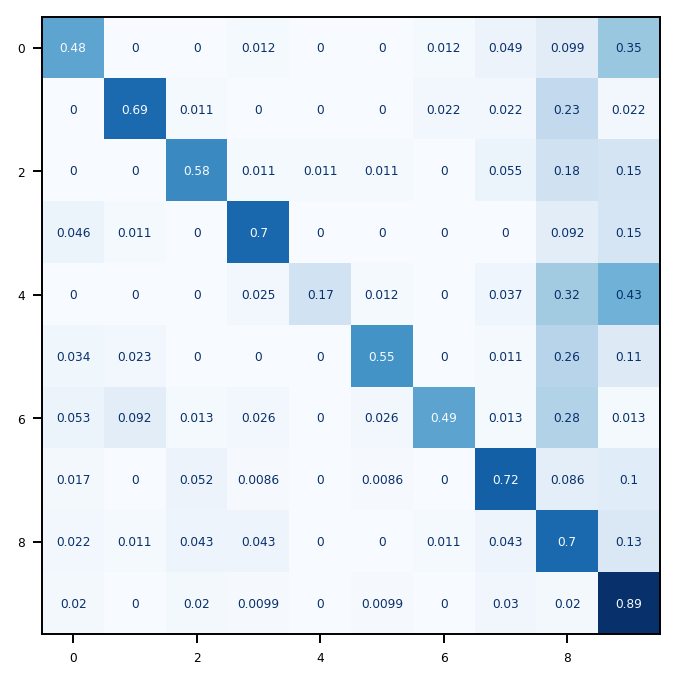

In [9]:



clf = RandomForestClassifier(max_depth=5, random_state=0)

param_grid = {'max_depth': [3, 5, 10],
              'min_samples_split': [2, 5, 10]}

sh = HalvingRandomSearchCV(clf, param_grid, cv=5,
                        factor=2, resource='n_estimators',
                        max_resources=30).fit(X_rf, y)
sh.best_estimator_



In [11]:


def rf_model():

  mlflow.autolog(exclusive=False)

  with mlflow.start_run():
    mlflow.log_param("example_param", "example_value")
    clf = RandomForestClassifier(max_depth=10,min_samples_split=5, n_estimators=8,
                        random_state=0 )
    clf.fit(X_train_rf, y_train)
    metrics(clf, X_test_rf, y_test)
    
    preds = clf.predict(X_test_rf)
    mlflow.log_metric("test f1-score", f1_score(y_test, preds, average = 'macro'))
    mlflow.log_metric("accuracy", accuracy_score(y_test, preds))


2023/10/21 17:38:44 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2023/10/21 17:38:44 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


F1-Score:  0.4582312797480463
Acurácia:  0.4584450402144772
              precision    recall  f1-score   support

      A#:maj       0.36      0.48      0.41        27
      C#:maj       0.53      0.54      0.53        39
       C:maj       0.41      0.46      0.44        37
      D#:maj       0.40      0.44      0.42        27
       D:maj       0.50      0.35      0.41        37
       E:maj       0.65      0.65      0.65        37
      F#:maj       0.49      0.52      0.50        33
       F:maj       0.42      0.46      0.44        50
      G#:maj       0.44      0.44      0.44        39
       G:maj       0.41      0.30      0.35        47

    accuracy                           0.46       373
   macro avg       0.46      0.46      0.46       373
weighted avg       0.46      0.46      0.46       373



## KNeighborsClassifier

### Tuning

In [15]:
from sklearn.neighbors import KNeighborsClassifier


knn = KNeighborsClassifier()

param_grid = {'n_neighbors': [5, 20, 50],
              'algorithm': ['kd_tree', 'ball_tree', 'auto'],
              'weights': ['uniform', 'distance']}

sh = HalvingRandomSearchCV(knn, param_grid, cv=5,
                        factor=2, random_state = 0, scoring = 'f1_macro').fit(X_rf, y)
sh.best_estimator_

KNeighborsClassifier(algorithm='kd_tree', weights='distance')

In [16]:
def knn_model():

  mlflow.autolog(exclusive=False)

  with mlflow.start_run():
    mlflow.log_param("example_param", "example_value")
    clf = KNeighborsClassifier(algorithm='kd_tree', weights='distance')
    clf.fit(X_train_rf, y_train)
    metrics(clf, X_test_rf, y_test)
    
    preds = clf.predict(X_test_rf)
    mlflow.log_metric("test f1-score", f1_score(y_test, preds, average = 'macro'))
    mlflow.log_metric("accuracy", accuracy_score(y_test, preds))


knn_model()

2023/10/22 15:51:41 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2023/10/22 15:51:42 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/10/22 15:53:19 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "e:\MDNE\.venv\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils."


F1-Score:  0.48867892849586214
Acurácia:  0.48257372654155495
              precision    recall  f1-score   support

      A#:maj       0.43      0.67      0.52        27
      C#:maj       0.63      0.44      0.52        39
       C:maj       0.28      0.32      0.30        37
      D#:maj       0.38      0.74      0.50        27
       D:maj       0.57      0.43      0.49        37
       E:maj       0.67      0.70      0.68        37
      F#:maj       0.67      0.48      0.56        33
       F:maj       0.58      0.36      0.44        50
      G#:maj       0.47      0.46      0.47        39
       G:maj       0.40      0.40      0.40        47

    accuracy                           0.48       373
   macro avg       0.51      0.50      0.49       373
weighted avg       0.51      0.48      0.48       373

